<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Gunaev-agents" data-toc-modified-id="Gunaev-agents-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Gunaev agents</a></span></li></ul></div>

In [1]:
%load_ext autoreload
%autoreload 2

# add modules from parent package
import sys
sys.path.append('..')

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

## Gunaev agents

In [3]:
import itertools

import scipy.stats as ss
from joblib import Parallel, delayed

from bandits.pricing.bandits import PricingBernoulliBanditEnv
from bandits.pricing.agents import UCB1OAgent, SLRAgent, AggregatingAgent

from bandits.bandits import BernoulliBanditEnv
from bandits.agents import EpsilonGreedyAgent, UCB1Agent, ThompsonSamplingBetaAgent

from copy import deepcopy
from bandits.online_models import ConstantModel, SimpleLinearRegressor, OnlinePredictionEnv
from bandits.aggregating_algorithms import SimpleMeanAggregatingAlgorithm, Hedge

In [4]:
np.random.seed(2)
N_SIMULATIONS = 50
T = 10000

eps = 1e-2  # probability of exploration
alpha = 1

In [5]:
p_min = 1
p_max = 10
K = 10
dist_mean = 2
dist_std = 3
dist = ss.norm(loc=dist_mean, scale=dist_std)

<>:12: DeprecationWarning: invalid escape sequence \s
<>:21: DeprecationWarning: invalid escape sequence \m


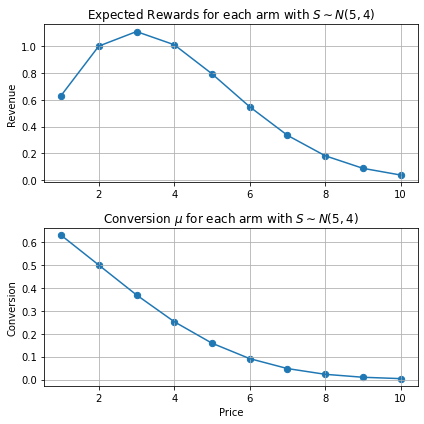

In [6]:
fig,axs=plt.subplots(figsize=(6, 6))

plt.subplot(2, 1, 1)
arms = np.linspace(p_min, p_max, K)
mus = 1-dist.cdf(arms)
rewards = arms*mus
plt.plot(arms, rewards)
plt.scatter(arms, rewards, s=40)
# plt.xticks(arms)
plt.grid()
plt.ylabel('Revenue')
plt.title('Expected Rewards for each arm with $S \sim N(5, 4)$');

plt.subplot(2, 1, 2)
plt.plot(arms, mus)
plt.scatter(arms, mus, s=40)
# plt.xticks(arms)
plt.grid()
plt.ylabel('Conversion')
plt.xlabel('Price')
plt.title('Conversion $\mu$ for each arm with $S \sim N(5, 4)$')
fig.tight_layout();

In [7]:
def simulate_agent(T, K, dist, p_min, p_max, agent_tuple, rng_seed=1):
    np.random.seed(rng_seed+1)
    env = PricingBernoulliBanditEnv(num_arms=K, dist=dist, p_min=p_min, p_max=p_max)
    # print(env.max_reward)
    # print(env.mus.round(3))
    # print(env.mus * env.action_to_price)
    
    name, agent_func = agent_tuple
    agent = agent_func(env)
    observation = env.reset()  # initial observation
    reward_history = []
    for _ in range(T):
        # print('choosing action')
        action = agent.get_action(observation)
        observation, reward, done, info = env.step(action)
        # print('step', observation, reward, done, info)
        reward_history.append(reward)
        agent.update_estimates(action, observation, reward)
    env.close()
    
    regret = np.cumsum(env.max_reward - reward_history)
    return rng_seed, name, regret

In [8]:
lr_models = [
    SimpleLinearRegressor(0, 0),
    SimpleLinearRegressor(0, 0, x_transform=np.log),
    SimpleLinearRegressor(0, 0, x_transform=np.log, y_transform=np.log1p, y_inv_transform=np.expm1),
    SimpleLinearRegressor(0, 0, x_transform=lambda x: 1/x),
]
gunaev_agg_alg = SimpleMeanAggregatingAlgorithm(lr_models)
hedge_agg_alg = Hedge(lr_models)

agent_funcs = [
    ("UCB1", lambda env: UCB1Agent(alpha=alpha, num_arms=env.action_space.n, reward_normalization=2*p_max)),
    ("SLRAgent", lambda env: SLRAgent(alpha=alpha, action_to_price=env.action_to_price)),
    ("Gunaev", lambda env: deepcopy(AggregatingAgent(aggregating_algorithm=gunaev_agg_alg, alpha=alpha, action_to_price=env.action_to_price))),
    ("Hedge", lambda env: deepcopy(AggregatingAgent(aggregating_algorithm=hedge_agg_alg, alpha=alpha, action_to_price=env.action_to_price))),
]

Ns = np.arange(N_SIMULATIONS)
combinations = list(itertools.product(Ns, agent_funcs))

In [9]:
# np.random.seed(1)
# # just to check if it works
# for n_simulation, agent_tuple in tqdm(combinations):
#     simulate_agent(T, K, dist, p_min, p_max, agent_tuple, n_simulation)
#     break

In [10]:
n_jobs = 8
verbose = False

results = Parallel(n_jobs=n_jobs, backend='loky', verbose=verbose)(
    delayed(simulate_agent)(T, K, dist, p_min, p_max, agent_tuple, n_simulation) for n_simulation, agent_tuple in tqdm(combinations))

  0%|          | 0/200 [00:00<?, ?it/s]

In [17]:
123

123

In [11]:
results_df = pd.DataFrame(results, columns=['simulation', 'algorithm', 'regret'])

In [12]:
results_df.head()

,simulation,algorithm,regret
0,0,UCB1,"[0.10832402054529089, -0.7833519589094182, 0.3..."
1,0,SLRAgent,"[0.10832402054529089, -0.7833519589094182, 0.3..."
2,0,Gunaev,"[0.10832402054529089, -0.7833519589094182, 0.3..."
3,0,Hedge,"[0.10832402054529089, -0.7833519589094182, 0.3..."
4,1,UCB1,"[0.10832402054529089, 1.2166480410905818, 2.32..."


In [13]:
agent_to_regret = results_df.groupby('algorithm').apply(lambda x: np.array(x['regret'].to_list())).to_dict()

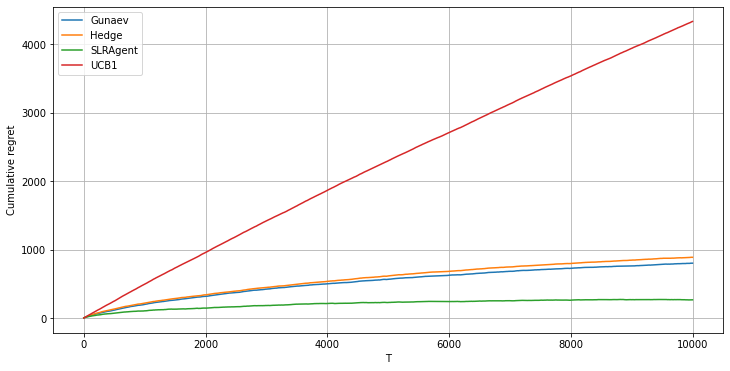

In [14]:
fig,axs=plt.subplots(figsize=(12, 6))
ts = np.arange(T)
for name, regret in agent_to_regret.items():
    sns.lineplot(x=ts, y=np.mean(regret, axis=0), label=name)
plt.xlabel('T')
plt.ylabel('Cumulative regret')
plt.grid();

hmm, hedge is slightly higher and LR is doing absolutely fine

maybe tinker with parameters

In [15]:
# agents = ['UCB1-O', 'SLRAgent', 'Gunaev']
agents = ['SLRAgent', 'Gunaev', 'Hedge']
relative_regrets = {}

ucb1_regret_cumsum = np.mean(agent_to_regret['UCB1'], axis=0)
for agent_name in agents:
    regret_cumsum = np.mean(agent_to_regret[agent_name], axis=0)
    relative_regret = regret_cumsum/ucb1_regret_cumsum

    # removing the first observations for numerical stability
    relative_regret = relative_regret[100:]
    
    relative_regrets[agent_name] = relative_regret

SLRAgent
Gunaev
Hedge


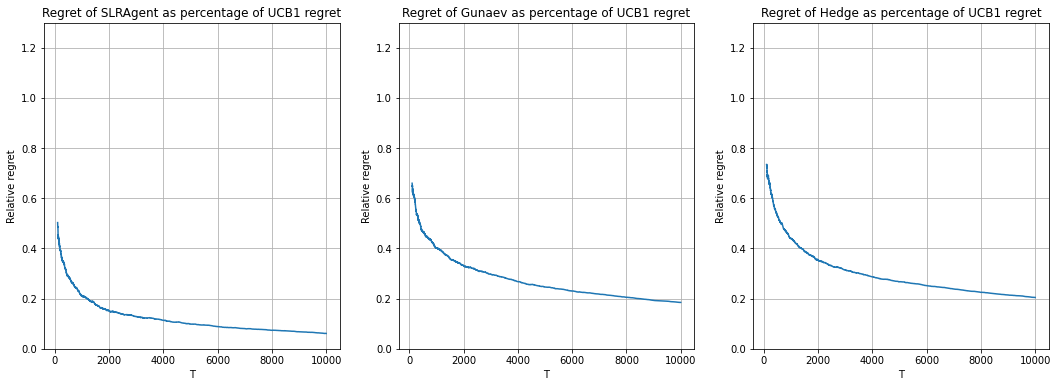

In [16]:
fig,axs=plt.subplots(figsize=(18, 6))


for i, agent_name in enumerate(agents):
    plt.subplot(1, 3, i+1)
    ts = np.arange(100, T)
    print(agent_name)
    plt.plot(ts, relative_regrets[agent_name])
    plt.xlabel('T')
    plt.ylabel('Relative regret')
    plt.title(f'Regret of {agent_name} as percentage of UCB1 regret')
    plt.grid()
    plt.ylim(0, 1.3);

In [ ]:
relative_regrets['Gunaev'][:100] - relative_regrets['Hedge'][:100]